# PROJECT-3. Анализ воронки

## ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

### Гипотеза 1
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

### Гипотеза 2
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

### Гипотеза 3
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

### Задачи:
Определить, насколько обучение сокращает время прохождения этапов игры.

Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

Определить, насколько прозрачен процесс взаимодействия с игрой.

Загружаем данные:

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
events_df = pd.read_csv('C:/Users/admin/Desktop/skillfactory/IDE/events.csv')
purchase_df = pd.read_csv('C:/Users/admin/Desktop/skillfactory/IDE/purchase.csv')

Подготавливаем таблицы:

In [139]:
# фильтруем: необходимы пользователи, зарегистрировавшиеся в 2018 году
mask = (events_df.start_time >= '2018-01-01') & (events_df.start_time < '2019-01-01') \
    & (events_df.event_type == 'registration')
b_list = events_df[mask].user_id.unique() # список уникальных пользователей за 2018 год
events_2018 = events_df[events_df.user_id.isin(b_list)] # датафрейм событий
events_2018.info() # информация о таблице зарегстрировавшихся в 2018 году

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


In [140]:
purchase_2018 = purchase_df[purchase_df.user_id.isin(b_list)] # пользователи за 2018
purchase_2018.info() # информация о таблице покупок в 2018 году

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1600 non-null   int64 
 1   user_id         1600 non-null   int64 
 2   event_datetime  1600 non-null   object
 3   amount          1600 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


Готовим общую таблицу

In [141]:
# переименовываем столбцы, чтобы объединить таблицы
events_2018 = events_2018.rename(columns={'id': 'event_id'})
purchase_2018 = purchase_2018.rename(columns={'id': 'purchase_id', 'event_datetime': 'start_time'})

# выбираем признак 'покупка' ('purchhase')
purchase_2018['event_type'] = 'purchase'

# объединяем таблицы, сбрасываем индексы, сортируем, преобразуем столбец дат
total_events_2018 = pd.concat([events_2018, purchase_2018], sort = False)
total_events_2018 = total_events_2018.reset_index(drop = True).sort_values('start_time')
total_events_2018.start_time = pd.to_datetime(total_events_2018.start_time)

display(total_events_2018.head()) # отображаем первые 5 строк таблицы 
total_events_2018.info() # информация о таблице событий за 2018 году

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.7+ MB


#  Задача 1: определим, насколько обучение сокращает время прохождения этапов игры.
Чтобы это понять, сравним время прохождения различных этапов для пользователей, завершивших обучение, и пользователей, не начинавших обучение.

In [142]:
x = total_events_2018['event_type'].unique()
display(x) # отобразим события в event_type

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

In [143]:
# Делим датафреймы
users_tutorial_finish = total_events_2018[total_events_2018["event_type"] \
    == "tutorial_finish"].user_id.unique() # пользователи, закончившие обучение

users_tutorial_start = total_events_2018[total_events_2018["event_type"] \
    == "tutorial_start"].user_id.unique() # пользователи, начавшие обучение

users_without_tutorial1 = total_events_2018.user_id.apply(lambda x: x if x not in \
    users_tutorial_start else False) 

users_without_tutorial = users_without_tutorial1[users_without_tutorial1 != False].to_list()
# пользователи, не начинавшие обучение

total_events_whith = total_events_2018[total_events_2018.user_id.isin(users_tutorial_finish)] 
# датафрейм пользователей с обучением

total_events_whithout = total_events_2018[total_events_2018.user_id.isin(users_without_tutorial)] 
# датафрейм пользователей без обучения

### Пользователи, завершишие обучение:

In [144]:
# готовим датафреймы
registration_df = total_events_whith[total_events_whith['event_type'] \
    == 'registration'][['user_id','start_time']]

level_choice_df = total_events_whith[total_events_whith['event_type'] \
    == 'level_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')

level_choice_df = level_choice_df.rename(columns = {'start_time' : 'level_choice_time'}) 
# датафрейм со временем выбора уровня сложности

pack_choice_df = total_events_whith[total_events_whith['event_type'] \
    == 'pack_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')

pack_choice_df = pack_choice_df.rename(columns = {'start_time' : 'pack_choice_time'}) 
# датафрейм со временем выбора бесплатного пакета вопросов

purchase = total_events_whith[total_events_whith['event_type'] \
    == 'purchase'][['user_id','start_time']]

purchase = purchase.rename(columns = {'start_time' : 'purchase_time'}) 
# датафрейм со временем оплат

print("каждый пользователь покупает 1 раз?", purchase.user_id.count() \
    == purchase.user_id.nunique())
print("каждый пользователь выбирает пакет 1 раз?", pack_choice_df.user_id.count() \
    == pack_choice_df.user_id.nunique())
print("каждый пользователь выбирает сложность 1 раз?", level_choice_df.user_id.count() \
    == level_choice_df.user_id.nunique())

каждый пользователь покупает 1 раз? True
каждый пользователь выбирает пакет 1 раз? True
каждый пользователь выбирает сложность 1 раз? True


Соединим датафреймы:

In [145]:
total_df = registration_df.merge(level_choice_df, how = 'left', on = 'user_id')
total_df = total_df.merge(pack_choice_df, how = 'left', on = 'user_id')
total_df = total_df.merge(purchase, how = 'left', on = 'user_id')

total_df.head() # первые пять строк датафрейма

,user_id,start_time,level_choice_time,pack_choice_time,purchase_time
0,27833,2018-01-01 04:07:25,NaT,NaT,NaT
1,27834,2018-01-01 08:35:10,NaT,NaT,NaT
2,27835,2018-01-01 11:54:47,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT
3,27836,2018-01-01 13:28:07,NaT,NaT,NaT
4,27839,2018-01-01 18:24:01,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT


### Пользователи, не начинавшие обучение

In [146]:
# готовим датафреймы
registration_df1 = total_events_whithout[total_events_whithout['event_type'] \
    == 'registration'][['user_id','start_time']]

level_choice_df1 = total_events_whithout[total_events_whithout['event_type'] \
    == 'level_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')

level_choice_df1 = level_choice_df1.rename(columns = {'start_time' : 'level_choice_time'}) 
# датафрейм со временем выбора уровня сложности

pack_choice_df1 = total_events_whithout[total_events_whithout['event_type'] \
    == 'pack_choice'][['user_id','start_time']].sort_values('start_time').drop_duplicates('user_id')

pack_choice_df1 = pack_choice_df1.rename(columns = {'start_time' : 'pack_choice_time'}) 
# датафрейм со временем выбора бесплатного пакета вопросов

purchase1 = total_events_whithout[total_events_whithout['event_type'] \
    == 'purchase'][['user_id','start_time']]

purchase1 = purchase1.rename(columns = {'start_time' : 'purchase_time'}) 
# датафрейм со временем оплат

print("каждый пользователь покупает 1 раз?", purchase1.user_id.count() \
    == purchase1.user_id.nunique())
print("каждый пользователь выбирает пакет 1 раз?", pack_choice_df1.user_id.count() \
    == pack_choice_df1.user_id.nunique())
print("каждый пользователь выбирает сложность 1 раз?", level_choice_df1.user_id.count() \
    == level_choice_df1.user_id.nunique())

каждый пользователь покупает 1 раз? True
каждый пользователь выбирает пакет 1 раз? True
каждый пользователь выбирает сложность 1 раз? True


Соединим датафреймы

In [147]:
total_df1 = registration_df1.merge(level_choice_df1, how = 'left', on = 'user_id') 
# соединяем "слева" по ключу 'user_id'
total_df1 = total_df1.merge(pack_choice_df1, how = 'left', on = 'user_id')
total_df1 = total_df1.merge(purchase1, how = 'left', on = 'user_id')

total_df.head() # первые пять строк датафрейма

,user_id,start_time,level_choice_time,pack_choice_time,purchase_time
0,27833,2018-01-01 04:07:25,NaT,NaT,NaT
1,27834,2018-01-01 08:35:10,NaT,NaT,NaT
2,27835,2018-01-01 11:54:47,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT
3,27836,2018-01-01 13:28:07,NaT,NaT,NaT
4,27839,2018-01-01 18:24:01,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT


Подготовим датафреймы для визуализации

In [148]:
total_df1['group_without'] = 'no_tutorial' # новый признак, без обучения и с обучением
total_df['group_without'] = 'yes_tutorial'

display('Воронка - пользователи без обучения', total_df1.count(), 
      'Воронка - пользователи с обучением',
       total_df.count())

vizual_df = total_df.count()
vizual_df1 = total_df1.count()

'Воронка - пользователи без обучения'

user_id              8068
start_time           8068
level_choice_time      98
pack_choice_time       74
purchase_time          22
group_without        8068
dtype: int64

'Воронка - пользователи с обучением'

user_id              10250
start_time           10250
level_choice_time     7501
pack_choice_time      5176
purchase_time         1447
group_without        10250
dtype: int64

In [149]:
# готовим датафреймы для визуализации данных

vizual_df = pd.DataFrame(vizual_df, index = vizual_df.index)
vizual_df = vizual_df.rename_axis('События').reset_index()
vizual_df.columns = ['События', 'Число пользователей']
vizual_df = vizual_df.loc[1:4, :]

vizual_df1 = pd.DataFrame(vizual_df1, index = vizual_df1.index)
vizual_df1 = vizual_df1.rename_axis('События').reset_index()
vizual_df1.columns = ['События', 'Число пользователей']
vizual_df1 = vizual_df1.loc[1:4, :]

# здесь 'start_time' - время регистрации
display(vizual_df)
display(vizual_df1)

,События,Число пользователей
1,start_time,10250
2,level_choice_time,7501
3,pack_choice_time,5176
4,purchase_time,1447


,События,Число пользователей
1,start_time,8068
2,level_choice_time,98
3,pack_choice_time,74
4,purchase_time,22


Визуализация воронки

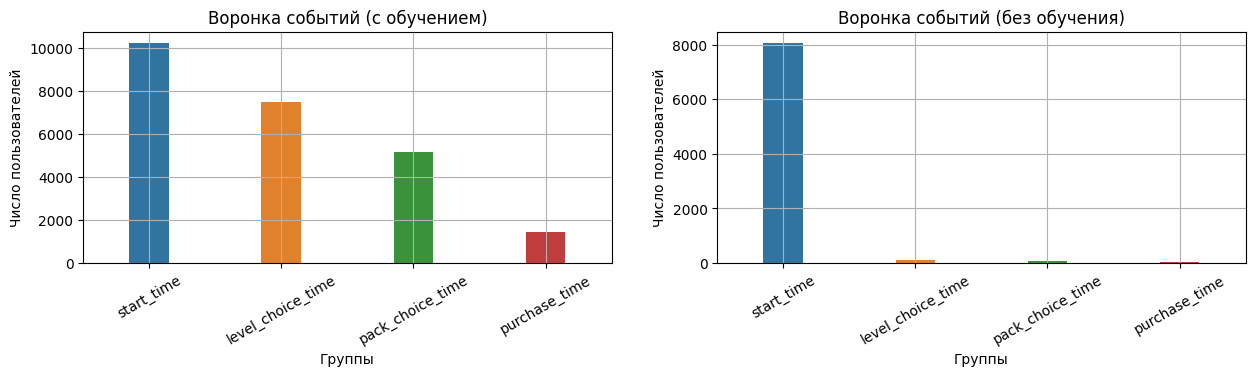

In [150]:
fig,axes = plt.subplots(1,2, figsize = (15,3))

sns.barplot(
    data=vizual_df,
    x = 'События',
    y = 'Число пользователей',
    orient='v',
    width=0.3,
    ax = axes[0]);

axes[0].set_title('Воронка событий (с обучением)')
axes[0].set_xlabel('Группы')
axes[0].grid()
axes[0].xaxis.set_tick_params(rotation=30)
    
sns.barplot(
    data=vizual_df1, 
    x = 'События',
    y = 'Число пользователей',
    orient='v',
    width=0.3,
    ax = axes[1]);

axes[1].set_title('Воронка событий (без обучения)')
axes[1].set_xlabel('Группы')
axes[1].grid()
axes[1].xaxis.set_tick_params(rotation=30)

# start_time - время регистрации, обязательный для всех параметр

### Воронка у группы, завершивших обучением, больше, чем у группы без обучения (группа, начавшая, но не завершившая обучения, будет рассмотрена далее).

In [151]:
# объединим датайремы в один
total_group_df = pd.concat([total_df, total_df1])
total_group_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18318 entries, 0 to 8067
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18318 non-null  int64         
 1   start_time         18318 non-null  datetime64[ns]
 2   level_choice_time  7599 non-null   datetime64[ns]
 3   pack_choice_time   5250 non-null   datetime64[ns]
 4   purchase_time      1469 non-null   datetime64[ns]
 5   group_without      18318 non-null  object        
dtypes: datetime64[ns](4), int64(1), object(1)
memory usage: 1001.8+ KB


### Проверка имеющихся данных

In [152]:
# рассмотрели только две группы пользователей - прошедших обучение и необучавшихся 
# Посмотрим на пользователей, начавших, но не окончивших обучение
print('всего {} пользователей'.format(total_events_2018.user_id.nunique()))

print('закончили обучение {} пользователей.'.\
    format(total_events_2018[total_events_2018['event_type'] == 'tutorial_finish'].user_id.nunique()))

print('{} пользователей начали обучение, но не закончили.'.\
    format(total_events_2018[total_events_2018['event_type'] == 'tutorial_start'].user_id.nunique() -
total_events_2018[total_events_2018['event_type'] == 'tutorial_finish'].user_id.nunique()))

print('Количество пользователей с вычетом тех, кто не закончил обучение равно {}.'.\
    format(total_events_whithout.user_id.nunique() + total_events_whith.user_id.nunique()))

print('{} пользователей в новом объединённом датафрейме, количество совпадает.'.format\
    (total_group_df.user_id.nunique()))

count_all_users = total_events_2018.user_id.nunique() # используем в дальнейшем

всего 19926 пользователей
закончили обучение 10250 пользователей.
1608 пользователей начали обучение, но не закончили.
Количество пользователей с вычетом тех, кто не закончил обучение равно 18318.
18318 пользователей в новом объединённом датафрейме, количество совпадает.


In [153]:
# через diff считаем разницу во времени между каждым этапом по столбцам
# start_time - время регистрации

total_group_df = total_group_df.set_index('group_without') # уберем признак групп в иднекс датафрейма

total_diff_df = total_group_df[['start_time', 'level_choice_time', 'pack_choice_time', 'purchase_time']] \
    .diff(axis = 1)

total_diff_df.pivot_table(
    values=['level_choice_time', 'pack_choice_time', 'purchase_time'],
    columns = total_diff_df.index,
    aggfunc = ['describe']
) # создаем сводную таблицу с вычислением показателей с помощью агрегирующих методов. 

describe                           
group_without                          no_tutorial               yes_tutorial
level_choice_time 25%       0 days 02:15:28.500000            0 days 03:51:41
                  50%       0 days 04:56:05.500000            0 days 06:00:07
                  75%              0 days 08:24:01            0 days 09:25:42
                  count                         98                       7501
                  max              0 days 18:34:21            1 days 18:48:25
                  mean   0 days 05:15:33.122448979  0 days 07:05:36.854819357
                  min              0 days 00:09:26            0 days 00:08:15
                  std    0 days 03:41:00.594664298  0 days 04:30:23.231509186
pack_choice_time  25%       0 days 00:03:09.750000            0 days 00:03:05
                  50%       0 days 00:04:46.500000            0 days 00:04:58
                  75%       0 days 00:07:11.250000            0 days 00:07:11
                  count                         74                       5176
                  max              0 days 00:13:32            0 days 00:15:48
                  mean   0 days 00:05:23.824324324  0 days 00:05:18.146058732
                  min              0 days 00:00:48            0 days 00:00:19
                  std    0 days 00:03:01.230146431  0 days 00:02:44.449118501
purchase_time     25%              2 days 15:49:22     1 days 21:16:05.500000
                  50%              4 days 04:38:42            3 days 12:15:56
                  75%       5 days 23:34:55.750000     5 days 08:53:44.500000
                  count                         22                       1447
                  max              7 days 11:56:49           10 days 18:33:59
                  mean   4 days 04:49:33.590909090  3 days 17:17:59.641326883
                  min              0 days 09:35:48            0 days 00:44:50
                  std    2 days 04:58:40.602573417  2 days 04:31:59.804658578

In [154]:
# определим время между началом (регистрацией) и оплатой
total_group_df['delta'] =  total_group_df['purchase_time'] - total_group_df['start_time']
total_group_df.groupby(total_group_df.index)['delta'].describe()

,count,mean,std,min,25%,50%,75%,max
group_without,,,,,,,,
no_tutorial,22,4 days 09:06:01.909090909,2 days 05:12:16.748091626,0 days 09:59:07,2 days 21:31:31,4 days 11:29:09,6 days 02:28:47.750000,7 days 16:46:20
yes_tutorial,1447,4 days 00:30:03.247408431,2 days 04:47:29.946150698,0 days 04:36:58,2 days 04:09:55,3 days 19:04:59,5 days 15:46:14,11 days 00:35:04


In [155]:
# подготовим данные для визуализации
pivot = total_diff_df[['level_choice_time', 'pack_choice_time', 'purchase_time']]
pivot = (pivot[['level_choice_time', 'pack_choice_time', 'purchase_time']]/pd.Timedelta(hours = 1)).copy()
pivot = pivot.groupby(pivot.index)[['level_choice_time', 'pack_choice_time', 'purchase_time']].mean()
display(pivot)

,level_choice_time,pack_choice_time,purchase_time
group_without,,,
no_tutorial,5.259201,0.089951,100.825997
yes_tutorial,7.093571,0.088374,89.299900


'Таблица разности между оплатой и регистрацией для двух групп'

,count,mean,std,min,25%,50%,75%,max
group_without,,,,,,,,
no_tutorial,22,4 days 09:06:01.909090909,2 days 05:12:16.748091626,0 days 09:59:07,2 days 21:31:31,4 days 11:29:09,6 days 02:28:47.750000,7 days 16:46:20
yes_tutorial,1447,4 days 00:30:03.247408431,2 days 04:47:29.946150698,0 days 04:36:58,2 days 04:09:55,3 days 19:04:59,5 days 15:46:14,11 days 00:35:04


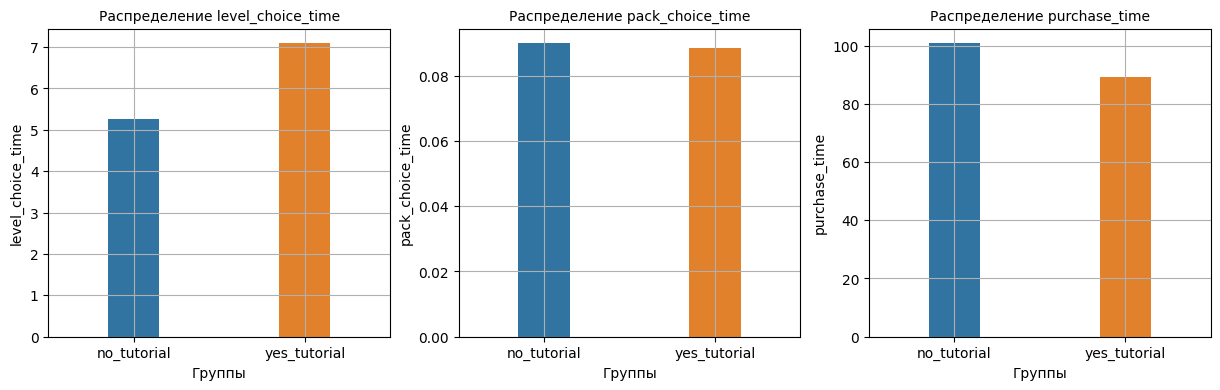

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
sns.barplot(
    data=pivot,
    y = 'level_choice_time', 
    orient='v',
    x = pivot.index,
    width=0.3,
    ax = axes[0]
)
axes[0].set_title('Распределение level_choice_time', fontsize = (10));
axes[0].set_xlabel('Группы')
axes[0].grid()

sns.barplot(
    data=pivot,
    y = 'pack_choice_time', 
    orient='v',
    x = pivot.index,
    width=0.3,
    ax = axes[1]
)
axes[1].set_title('Распределение pack_choice_time', fontsize = (10));
axes[1].grid()
axes[1].set_xlabel('Группы')

sns.barplot(
    data=pivot,
    y = 'purchase_time', 
    orient='v',
    x = pivot.index,
    width=0.3,
    ax = axes[2]
)
axes[2].set_title('Распределение purchase_time', fontsize = (10));
axes[2].set_xlabel('Группы')
axes[2].grid()

display('Таблица разности между оплатой и регистрацией для двух групп',\
    total_group_df.groupby(total_group_df.index)['delta'].describe())

Для пользователей, прошедших обучение, процесс оплаты с момента регистрации в среднем на 8,5 часов меньше, чем у пользователей, не прошедших обучение, далее будем их называть группа 1 (с обучением) и 2 (без обучения).

Группа 1 выбирает уровень сложности на 2,2 часа дольше, чем группа 2. Далее группа 1 выбирает бесплатный пакет и покупает платный пакет вопросов быстрее (5 минут и 11 часов соответственно). В конечном счете группа 1 совершает оплату раньше. 

## Вывод
Обучение влияет на скорость прохождения других этапов игры. Время между этапами у пользователей, прошедших обучение, с пользователями, не прошедшими обучение, различается.

# Задача 2: проверим, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

In [157]:
# продолжаем работу с датафреймом - total_events_2018
total_events_2018 = total_events_2018.reset_index(drop=True).sort_values(['user_id','start_time'])
# удаляем индексы, сортируем по 'user_id' и 'start_time'
user_path_df = total_events_2018.groupby("user_id")["event_type"].apply(list).reset_index()
# создаем сгруппированный датафрейм  
display(user_path_df.head())

# преобразуем кортеж в строку в каждой ячейке для ускорения обработки данных
user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))
user_path_df["event_path"].head() 

,user_id,event_type
0,27832,[registration]
1,27833,"[registration, tutorial_start, tutorial_finish]"
2,27834,"[registration, tutorial_start, tutorial_finish]"
3,27835,"[registration, tutorial_start, tutorial_finish..."
4,27836,"[registration, tutorial_start, tutorial_start,..."


0                                         registration
1      registration > tutorial_start > tutorial_finish
2      registration > tutorial_start > tutorial_finish
3    registration > tutorial_start > tutorial_finis...
4    registration > tutorial_start > tutorial_start...
Name: event_path, dtype: object

In [158]:
# рассмотрим самые популярные пользовательские пути
user_paths = (
    user_path_df.groupby(["event_path"])["user_id"]
    .nunique()
    .sort_values(ascending=False)
)
user_paths.head()

event_path
registration                                                                               7970
registration > tutorial_start > tutorial_finish > level_choice > pack_choice               2796
registration > tutorial_start > tutorial_finish                                            1956
registration > tutorial_start > tutorial_finish > level_choice                             1713
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase    1083
Name: user_id, dtype: int64

In [159]:
# Ищем последовательности с оплатой
display(user_paths[user_paths.index.str.contains('purchase')].head())

event_path
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                       1083
registration > tutorial_start > level_choice > pack_choice > purchase                                                          124
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start > tutorial_finish > purchase     101
registration > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase      52
registration > tutorial_start > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                        26
Name: user_id, dtype: int64

In [160]:
# Ищем последовательности с оплатой и обучением
mask1 = user_paths.index.str.contains('purchase')
mask2 = user_paths.index.str.contains('tutorial_start')

display(user_paths[(mask1)&(mask2)].head()) # самые популярные пути с оплатой и обучением

purchase_count = user_paths[(mask1)&(mask2)]
print('{} оплат, где было хотя бы 1 обучение'.format(purchase_count.sum()))
print(total_events_2018.amount.count(), '- общее количество оплат')

purchase_count = user_paths[(mask1)&(mask2)] # оставим 6 самых популярный путей для графика

event_path
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                       1083
registration > tutorial_start > level_choice > pack_choice > purchase                                                          124
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start > tutorial_finish > purchase     101
registration > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase      52
registration > tutorial_start > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                        26
Name: user_id, dtype: int64

1578 оплат, где было хотя бы 1 обучение
1600 - общее количество оплат


Итого у нас получилось 1600 оплат, из них 1578 приходится на пользователей с обучением.
1447 пользователей завершили обучение или прошли его дважды. 
1578 - 1447 = 131 оплата на пользователей с незаконченным обучением.
22 пользователя совершили покупку не обучаясь.

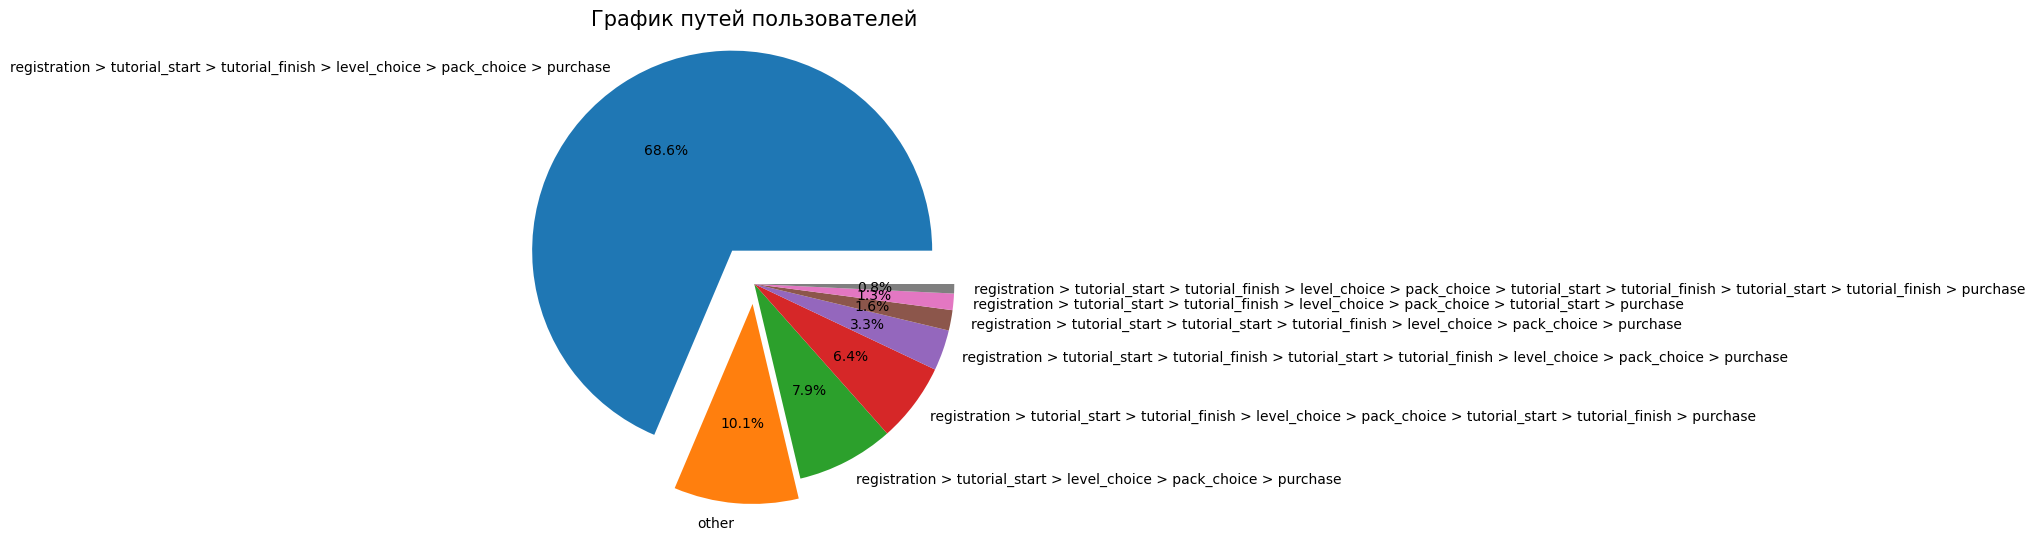

In [161]:
purchases = pd.Series(purchase_count).sort_values(ascending=False)
#выделяем ТОП-7 путей и добавляем категорию 'other'
purchases['other'] = purchases[7:].sum()
purchases = purchases.sort_values(ascending=False)[:8]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    purchases,
    labels=purchases.index,
    autopct='%.1f%%',    
    explode = [0.2, 0.1, 0, 0, 0, 0, 0, 0]
);
axes.set_title('График путей пользователей'\
    , fontsize = 15);

### Вывод 
Зависимость между вероятностью оплаты и количеством обучений отсутствует. 68.6% пользователей закончили обучение 1 раз и сделали покупку. Также заметно, что чем больше обучений проходит пользователь, тем меньше покупок совершается.

Рассмотрим группы пользователей по количеству обучений

In [162]:
tutorial_df = total_events_2018[total_events_2018['event_type'].isin(['tutorial_start'])][['user_id', 'event_type']]
tutorial_df = tutorial_df.user_id.value_counts().sort_values()
tutorial_df = tutorial_df.reset_index()
tutorial_df.columns = ['user_id', 'number_groups']
display(tutorial_df.number_groups.unique()) # номера групп по количеству обучений:группа 1 - 1 обучение, группа 2 - 2 обучения...

# соединим датафрейм с исходным
total_events_2018 = total_events_2018.merge(tutorial_df, on = 'user_id', how = 'inner')

# подготовим датафрейм для подсчёта конверсии в покупку для каждой группы
tutorial_df2 = total_events_2018.groupby('number_groups', as_index = False)[['user_id', 'purchase_id']].nunique()
#  напомню, что 1 пользователь совершает покупку 1 раз. Поэтому считаю через метод: nunique

print(tutorial_df2.info()) # промежуточный результат

tutorial_df2['percent'] = round(100 * tutorial_df2.purchase_id/tutorial_df2.user_id,2)

# переименуем столбцы
tutorial_df2.columns = ['number_groups',  'count_user_id',  'count_purchase_id', 'percent'] 
tutorial_df2 = tutorial_df2.sort_values('percent', ascending = False)
display(tutorial_df2)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   number_groups  9 non-null      int64
 1   user_id        9 non-null      int64
 2   purchase_id    9 non-null      int64
dtypes: int64(3)
memory usage: 344.0 bytes
None


,number_groups,count_user_id,count_purchase_id,percent
7,8,86,13,15.12
8,9,113,17,15.04
4,5,109,16,14.68
1,2,1589,218,13.72
3,4,221,30,13.57
0,1,9103,1207,13.26
6,7,94,12,12.77
5,6,116,14,12.07
2,3,427,51,11.94


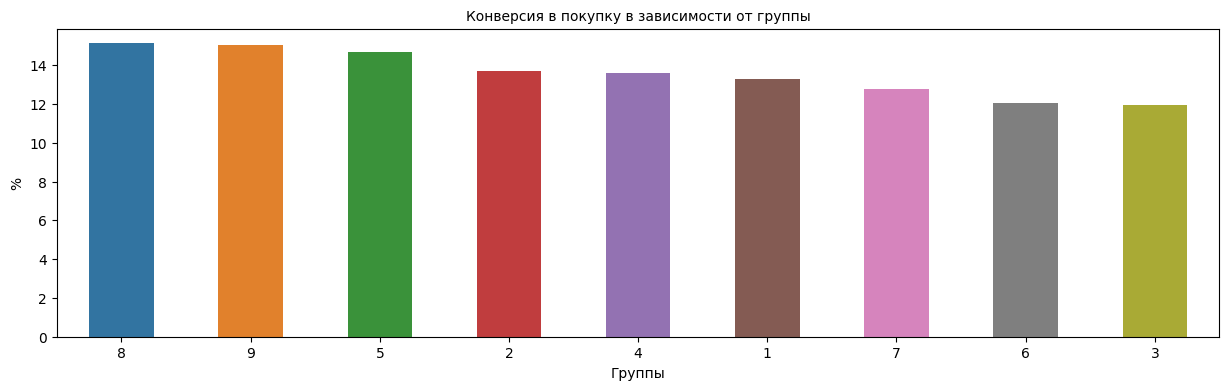

In [163]:
# построим график
fig = plt.figure(figsize=(15,4))
barplot1 = sns.barplot(
    data= tutorial_df2[['percent', 'number_groups']] ,
    y = 'percent', 
    x = 'number_groups',
    orient='v',
    order = tutorial_df2.sort_values(by = 'percent', ascending = False).number_groups,
    width = 0.5);

barplot1.set_title('Конверсия в покупку в зависимости от группы', fontsize = (10)); 
# номер группы равен количеству обучений 
barplot1.set_ylabel('%')
barplot1.set_xlabel('Группы');

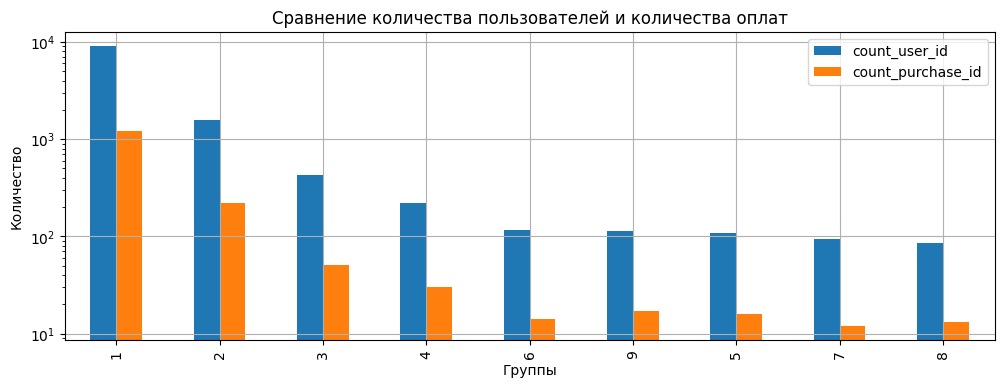

In [164]:
# отсортируем и построим еще один график
tutorial_df2.sort_values(by ='count_user_id', inplace = True, ascending = False)

tutorial_df2[['number_groups', 'count_user_id', 'count_purchase_id']].set_index('number_groups').plot(
    kind='bar',
    grid=True,
    title = 'Сравнение количества пользователей и количества оплат',
    legend = True,
    figsize=(12, 4),
    logy = True, # используем логарифмический график для корректного отображения масштабов
    xlabel = 'Группы',
    ylabel = 'Количество'
);
    

Как видно из графика, распредение количества пользователей и количества оплат, прошедшие обучение 5 и более раз, примерно одинаково.


### Вывод
Обучение влияет на вероятность оплаты и не зависит от количества обучений. Например, больше всего покупок у пользователей, прошедших обучение 1 раз. Покупки и количество пользователей, прошедших обучение от 5 до 9 раз, примерно одинаковое. Видимо, не всем пользователям понятно обучение, поэтому им приходится проходить обучение несколько раз, прежде чем произвести покупку. 

# Задача 3: определим, насколько прозрачен процесс взаимодействия с игрой.
Выясним, как часто пользователи начинают обучение после выбора уровня сложности (это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна).

In [165]:
# сформируем фильтр по событию : выбор уровня сложности и начала обучения
display(user_paths[user_paths.index.str.contains('level_choice > tutorial_start')].head())

event_path
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                                                          169
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start                                                                                             39
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish                                        31
registration > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                        17
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish     12
Name: user_id, dtype: int64

Рассмотрим разные комбинации, где этап обучения был выбран после сложности. Определим разность между столбцами времения обучения и времени выбора уровня сложности. Необхоимые значения будут иметь положительный результат.

In [166]:
# сформируем датафреймы
level_choice_df = total_events_2018[total_events_2018['event_type'] == 'level_choice'][['user_id', 'start_time']]
tutorial_start_df = total_events_2018[total_events_2018['event_type'] == 'tutorial_start'][['user_id', 'start_time']]

level_choice_df = level_choice_df.rename(
    columns={"start_time": "level_choice_time"}
)
                   
tutorial_start_df = tutorial_start_df.rename(
    columns={"start_time": "tutorial_start_time"}
)                                                   

# объединим датафреймы
transparency_df = tutorial_start_df.merge(level_choice_df, on ='user_id', how = 'inner')               
transparency_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12686 entries, 0 to 12685
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              12686 non-null  int64         
 1   tutorial_start_time  12686 non-null  datetime64[ns]
 2   level_choice_time    12686 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 396.4 KB


In [167]:
# выберем пользователей, начавших обучение после выбора сложности
transparency_df['time'] = transparency_df.tutorial_start_time - transparency_df.level_choice_time
transparency_df['time'] = transparency_df['time']/pd.Timedelta(hours = 1) 
transparency_df = transparency_df[transparency_df['time'] > 0]
display(transparency_df)

# считаем пользователей
print('{} пользователей, начавших обучение после выбора сложности; доля таких пользователей - {} %'.\
        format( (transparency_df.user_id.nunique()), (round(100 * transparency_df.user_id.nunique()/count_all_users,2))))

,user_id,tutorial_start_time,level_choice_time,time
4,27842,2018-01-02 09:01:51,2018-01-02 08:46:03,0.263333
5,27842,2018-01-02 18:08:01,2018-01-02 08:46:03,9.366111
8,27845,2018-01-02 07:08:00,2018-01-02 06:19:18,0.811667
13,27852,2018-01-02 20:34:31,2018-01-02 18:39:44,1.913056
21,27862,2018-01-03 11:17:41,2018-01-03 04:19:32,6.969167
...,...,...,...,...
12630,47635,2018-12-28 17:28:42,2018-12-28 11:43:38,5.751111
12643,47657,2018-12-28 21:44:13,2018-12-28 21:25:49,0.306667
12644,47657,2018-12-28 21:53:06,2018-12-28 21:25:49,0.454722
12666,47711,2018-12-29 22:50:57,2018-12-29 21:23:23,1.459444


1386 пользователей, начавших обучение после выбора сложности; доля таких пользователей - 6.96 %


### Вывод
Около 7% пользователей начинают обучение после выбора сложности, что является достаточно неплохим показателем.